Sometimes I find myself reading a paper or trying to design a model or formulate an algorithm at work, when I suddenly stop short, stare at some primitive mathematical operation, and realise that I have no idea how it's done. This happended recently with the realization that I didn't know how to sampling non-uniform random variates from a number of basic probability distributions. I started pulling at threads and digging into papers, and ended up reading a good deal of Art Owen's and Luc Devroye's excellent books in an effort to fill in the gaps. This notebook has some details of some of the interesting things I've been learning that I wanted to explore, in particular the ratio-of-uniforms method for sampling.

In [1]:
# gimme gimme gimme
import numpy as np
import scipy.optimize as opt
import scipy.special as spf
import matplotlib.pyplot as plt

# abracadabra
%matplotlib inline
plt.style.use('ggplot')

# warnings? we don't need to stinkin' warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Some example log-density functions
logf_exponential = lambda x: -x if x >= 0 else -np.inf
logf_double_exponential = lambda x: -np.abs(x) - np.log(2)
logf_gamma = lambda x: (3 - 1) * np.log(x) -x - spf.gammaln(1 + 3) if x >= 0 else -np.inf
logf_normal = lambda x: -(x - 2)**2 / (2 * 4) - np.log(2 * np.pi * 4) / 2
logf_cauchy = lambda x: -np.log(np.pi * (1.0 + x**2))
logf_poisson = lambda x: -1 + np.floor(x) * np.log(1) - spf.gammaln(1 + np.floor(x)) if x >= 0 else -np.inf

# Ratio of Unifoms

The ratio of uniforms method works by uniformly sampling a random point in a 2D region of the plane, and then calculating the ratio of the coordinates to get a random variate with the desired distribution.

We'll start with continuous random variables, and we'll assume that the target distribution is generally nice in all appropriate ways and has density function $f(x)$.

## Outline and Derivation

Let's just dive in. Here are the steps...

### Sample a 2D point

Draw a sample $(u,v)$ uniformly from the region $C = \left\{ (u,v) : 0 \leq u \leq \sqrt{f(v/u)} \right\}$. For now, let's just assume that we can do this, without worrying about how. The density function is $f_{U,V}(u,v) = \frac{1}{K}$ where $K$ is the area of $C$, which of course we don't know. Let's not worry about that either for now.

### Transform

Being a bit sloppy with notation, define the transformation $(X, Y) = (V/U, U)$. The jacobian of this transformation is as follows.

\begin{equation}
J = \det \begin{bmatrix} \frac{\partial x}{\partial u} & \frac{\partial x}{\partial v} \\ \frac{\partial y}{\partial u} & \frac{\partial y}{\partial v} \end{bmatrix} = \det \begin{bmatrix} -\frac{v}{u^2} & \frac{1}{u} \\ 1 & 0 \end{bmatrix} = \frac{1}{u} = \frac{1}{y}
\end{equation}

Now we can work out the density in terms of $X, Y$, using the standard transformation.

\begin{equation}
p_{X, Y}(x, y) = \frac{1}{J} p_{U, V}(u, v) = \frac{y}{K}
\end{equation}

The support set becomes $C = \left\{ (x,y) : 0 \leq y \leq \sqrt{f(x)} \right\}$

### Marginalise

Now, marginalise $Y$.

\begin{align}
p_X(x) &= \int_C p_{X, Y}(x, y) dy \\
       &= \int_0^{\sqrt{f(x)}} \frac{y}{K} dy \\
       &= \frac{1}{K} \left[\frac{y^2}{2}\right]_0^{\sqrt{f(x)}} \\
       &= \frac{1}{2 \: K} \:f(x)
\end{align}

Neat. Finally, since $\int p_X(x) dx = 1$, we _must_ have had $K = \frac{1}{2}$ all along, with the area of $C$ being $2$. With this information, we end up with exactly what we wanted.

$$
p_X(x) = f(x)
$$

## Er... what?

When I first saw this, it all seemed... completely arbitrary and magical. Where did the whole $\sqrt{f(v/u)}$ thing come from? We need some intuition.

### Function Wrapping

First let's think about wrapping a function around a semi-circle. Suppose we have some function $g(x)$ defined for $x \in \mathbb{R}$. We can squash it into the interval $\left[-\frac{\pi}{2}, \frac{\pi}{2}\right]$ using $\theta = \tan^{-1} x$ to transform the input, such that $h(\theta) = g(\tan \theta)$. Now we can draw a curve to represent the function with _polar_ coordinates $(\theta, h(\theta))$. This is unique for each $g(x)$, and provides a nice way to visualize the function.

In [3]:
def draw_function_wrapped_around(f):
    
    # Make a grid for theta
    nearly_pi_on_two = np.pi/2 - 0.01
    th_range = np.arange(-nearly_pi_on_two, nearly_pi_on_two, 0.01)
    
    # Calculate h
    t_range = [np.tan(th) for th in th_range]
    h_range = [f(t) for t in t_range]
    
    # Convert to cartesian for plotting
    x_range = [h * np.cos(th) for (th, h) in zip(th_range, h_range)]
    y_range = [h * np.sin(th) for (th, h) in zip(th_range, h_range)]
    
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(x_range, y_range, 'b')

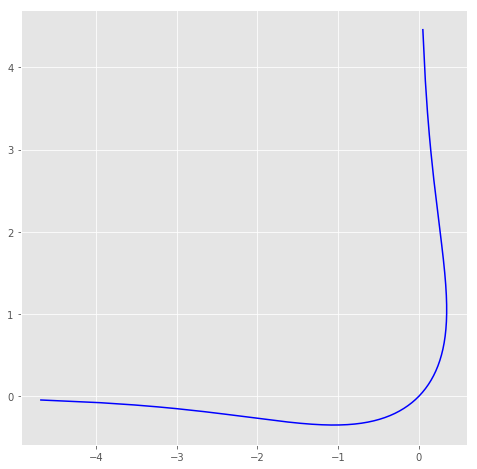

In [4]:
# Logarithm
draw_function_wrapped_around(lambda x: np.log(x))

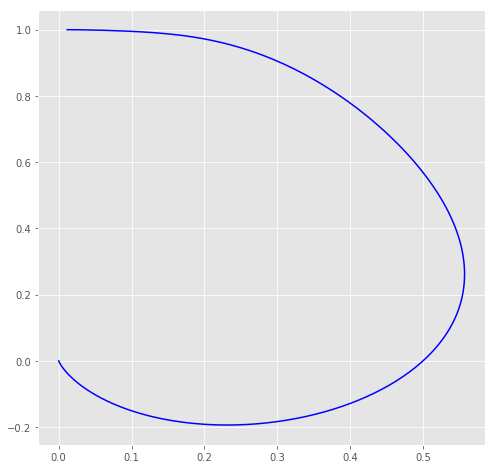

In [5]:
# Sigmoid
draw_function_wrapped_around(lambda x: 1.0 / (1.0 + np.exp(-x)))

If the function goes to $0$ as it goes to $\pm \infty$ (like a density function...) then the two ends will come back to the origin to form a closed region.

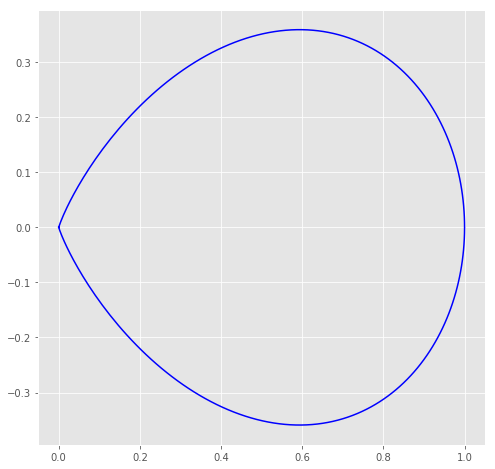

In [6]:
# Squared exponential
draw_function_wrapped_around(lambda x: np.exp(-x**2))

### Backwards Engineering

So what function $g(x)$ (and corresponding $f(\theta)$) do we need to put in in order to get our neat sampling-from-$f(x)$ property out?

Well, each value of $\theta$ in the plane corresponds to a unique value of $x$ in the original function. If we draw a uniform random sample from the region $C$ within our curve, then the probability of hitting the infinitessimal wedge with angle $d\theta$ associated with a particular $\theta$ will be $\frac{1}{K} h(\theta)^2 d\theta$, using small angle geometry. If we want the transformed sample $x = \tan^{-1}(\theta)$ to be drawn from $f(x)$ then we need the corresponding small element probability to be equal. This gives us a defining equation for $h(x)$.

\begin{equation}
\frac{1}{K} h(\theta)^2 d\theta = f(x) dx
\end{equation}

The Jacobian for this is $\frac{d x}{d \theta} = \frac{d}{d \theta}\tan\theta = \frac{1}{cos(x)^2}$, with which we can solve for $h(x)$.

\begin{equation}
h(\theta) = \sqrt{\frac{K f(\tan \theta)}{cos(\theta)^2}} \propto \frac{\sqrt{f(\tan\theta)}}{cos\theta}
\end{equation}
We can forget about the proportionality since scaling the shape up or down obviously won't affect the distribution of angles.

In summary, the shape we need to sample from has polar coordinates $\left(\theta, \frac{\sqrt{f(\tan\theta)}}{cos\theta}\right)$.

Finally, let $u$ and $v$ be the horizontal and vertical (i.e. cartesian) coordinates of each point.

\begin{align}
u &= \frac{\sqrt{f(\tan\theta)}}{cos\theta} \cos\theta &= \sqrt{f(\tan\theta)} \\
v &= \frac{\sqrt{f(\tan\theta)}}{cos\theta} \sin\theta &= \sqrt{f(\tan\theta)} \tan\theta \\
\end{align}

From this, taking the ratio of the two equations, it follows that $v/u = \tan\theta$, and hence we get the equation of the curve in $(u,v)$ coordinates as required.
$$
u = \sqrt{f(v/u)}
$$

## Pictures!

To draw these things, we'll use a regular grid of values for $\theta$, then calculate $t = \tan\theta$, and the $(u,v)$-coordinates are simple.

\begin{align}
u &= \sqrt{f(t)} \\
v &= t \cdot \sqrt{f(t)}
\end{align}

In [7]:
def draw_uv_region(logf):
    
    f = lambda x: np.exp(logf(x))
    
    # Make a grid for theta
    nearly_pi_on_two = np.pi - 0.01
    th_range = np.arange(-nearly_pi_on_two, nearly_pi_on_two, 0.001)
    
    # Calculate u and v
    t_range = [np.tan(th) for th in th_range]
    u_range = [np.sqrt(f(t)) for t in t_range]
    v_range = [u * t for (u, t) in zip(u_range, t_range)]
    
    # Plot it
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(u_range, v_range, 'r')
    ax.set_aspect('equal')
    
    return ax

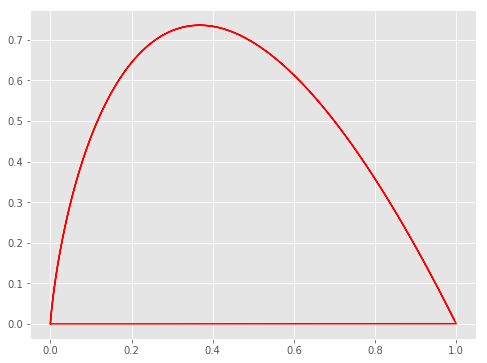

In [8]:
# Exponential
draw_uv_region(logf_exponential)
plt.show()

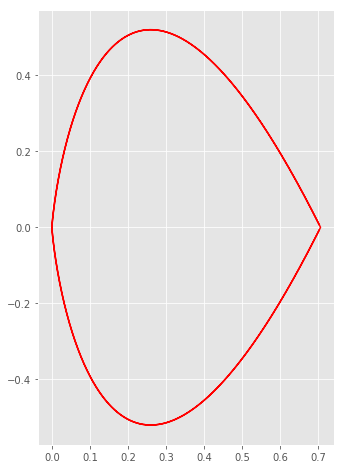

In [9]:
# Double Exponential
draw_uv_region(logf_double_exponential)
plt.show()

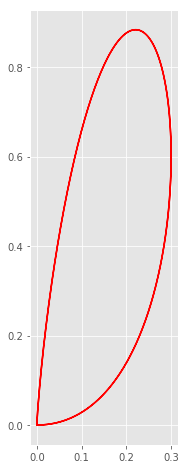

In [10]:
# Gamma
draw_uv_region(logf_gamma)
plt.show()

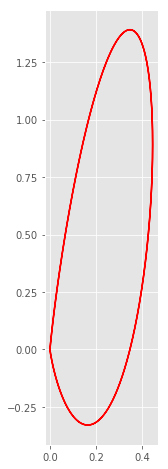

In [11]:
# Normal
draw_uv_region(logf_normal)
plt.show()

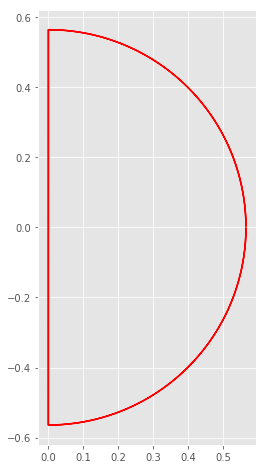

In [12]:
# Standard cauchy
draw_uv_region(logf_cauchy)  # It's a semi-circle!
plt.show()

We can use this for discrete random variables as well, using a little trick. Suppose the support of our discrete random variable is the non-negative integers. (If it isn't, we can map it to this set.) Let $p_k$ be the probability mass at $k$. Then construct a density function.

\begin{align}
f(x) &= p_{\lfloor x \rfloor}
\end{align}

Then $\int_{k}^{k+1} f(x) dx = p_k$. We've smeered each probability atom over the adjacent unit interval.

Once we've sampled $X_c$ from this continuous distirbution, we just set $X = \lfloor X_c \rfloor$ to get $X$ distributed according to our original discrete distribution.

Let's see what this looks like.

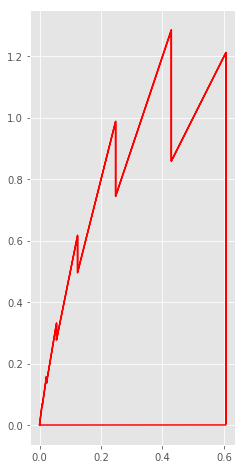

In [13]:
# Poisson
draw_uv_region(logf_poisson)
plt.show()

Well that was pleasing.

## Sampling

It's a nice principle - any density can be sampled just by sampling uniformly from the right shape and applying the transformation. But of course, there's no free lunch. Sampling uniformly from an irregular 2D region isn't much easier. It's just a new perspective from which to view the problem.

There are some distributions which map to a convenient geometric space in $(u, v)$ space from which we can sample, like the semi-circle for the cauchy distribution above. But these cases are rare.

We _can_ sample from any region using rejection sampling: Draw a box around the shape, sample uniformly from it, test whether the point is inside, and reject those that are not. The testing is easy, since it just follows from the definition of $C$. The hard bit is now working out how large the bounding box needs to be.

In the $u$-direction, there is an obvious bound. Let $f_{\max} = \max_x f(x)$, then since $u \leq \sqrt{f(v/u)} \Rightarrow u \leq \sqrt{f_{\max}}$. And of course $u > 0$ by construction. So that sets the width of our box.

On a similar tack, in the $v$-direction, we know that $-s \sqrt{f(-s)} \leq v \leq s \sqrt{f(s)}$ (where $s > 0$ is an arbitrary positive parameter). Define some more constants (and, indeed, assume that they exist).

\begin{align}
F_{+} &= \max_{s>0} [ s^2 f(s) ] \\
F_{-} &= \min_{s>0} [ -s^2 f(-s) ] = - \max_{s>0} [ s^2 f(-s) ]
\end{align}

Then $\sqrt{F_{-}} \leq v \leq \sqrt{F_{+}}$. That give us the top and bottom edges.

In [14]:
def upper_u_bound(logf):
    sol = opt.minimize(lambda x: -logf(x), 1.0, bounds=[(0.0, None)], method='L-BFGS-B')
    return np.sqrt(np.exp(-sol.fun))

def upper_v_bound(logf):
    sol = opt.minimize(lambda x: -(2 * np.log(x) + logf(x)), 1.0, bounds=[(0.0, None)], method='L-BFGS-B')
    return np.sqrt(np.exp(-sol.fun))

def lower_v_bound(logf):
    sol = opt.minimize(lambda x: -(2 * np.log(x) + logf(-x)), 1.0, bounds=[(0.0, None)], method='L-BFGS-B')
    return -np.sqrt(np.exp(-sol.fun))

In [15]:
def sample_from(logf, num_samples=1000):
    u_up = upper_u_bound(logf)
    v_up = upper_v_bound(logf)
    v_lo = lower_v_bound(logf)
    
    u = np.random.rand(num_samples) * u_up
    v = np.random.rand(num_samples) * (v_up - v_lo) + v_lo

    return list(zip(u, v))

In [16]:
def draw_box_samples(samples, ax, colour):
    (u, v) = zip(*samples)
    ax.plot(u, v, '.' + colour)

In [17]:
def reject_samples(samples, logf):
    f = lambda x: np.exp(logf(x))
    return [s for s in samples if s[0]**2 < f(s[1]/s[0])]

In [18]:
def show_me_sampling(logf):
    samples = sample_from(logf)
    retained_samples = reject_samples(samples, logf)
    
    ax = draw_uv_region(logf)
    draw_box_samples(samples, ax, 'b')
    draw_box_samples(retained_samples, ax, 'g')

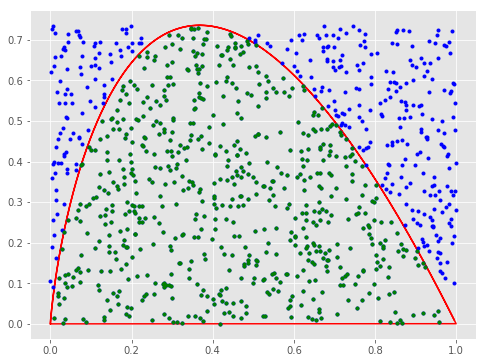

In [19]:
show_me_sampling(logf_exponential)

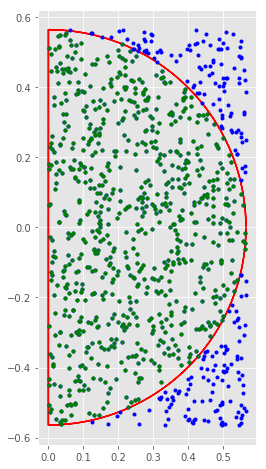

In [20]:
show_me_sampling(lambda x: -np.log(np.pi) - np.log(1.0 + x**2))

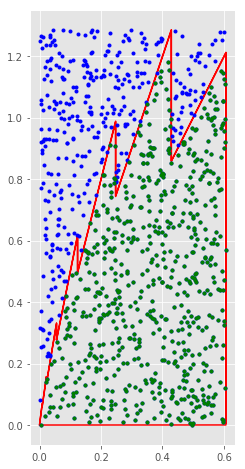

In [21]:
m = 1
show_me_sampling(lambda x: -m + np.floor(x) * np.log(m) - spf.gammaln(1 + np.floor(x)) if x >= 0 else -np.inf)

Well that was enormously pleasing. It turns out that this is basis of one of the most efficient algorithms for sampling from a Poisson distribution. Of course, there's lots of tweaks and optimizations to make that box fit as snugly as possible around the Poisson-shape and thus minimize the rejection rate. But this is the core of it. See Luc Devroye's excellent "Non-Uniform Random Variate Generation" for more.

## Some Assorted Final Thoughts

I really like this as an intuitive, visual way to understand sampling random variates. I found myself really quickly building up an intuiion of how geometric features of the $(u, v)$ shape correspond to properties of the underlying distribution. For example:
* An unbounded density function, like a gamma distribution with shape parameter less than $1$, has no upper bound in the $u$-direction.
* A distribution which is non-zero at $x=0$, like the exponential distribution, is non-zero on the $u$-axis.
* A distribution with heavy tails, like the Cauchy distribution, is non-zero on the $v$-axis.
* A distribution with _really_ heavy tails, like a Pareto distribution with shape parameter less than $1$, will go to $\infty$ in the $v$-direction.

Anyway, that's all. You can wrap a distribution around a half circle using $tan$ as the domain mapping, and it makes pretty shapes and useful sampling algorithms.

## Also...

Nice job, L-BFGS-B, in maximizing that utterly non-continuous poisson pdf.

## Refs

* Art B. Owen, [_Monte Carlo theory, methods and examples_](http://statweb.stanford.edu/~owen/mc/)
* Luc Devroye, [_Non- Uniform Random Variate Generation_](http://www.eirene.de/Devroye.pdf)
* A. J. Kinderman, J. F. Monahan, [_Computer Generation of Random Variables Using the Ratio of Uniform Deviates_](http://static.stevereads.com/papers_to_read/computer_generation_of_random_variables_using_the_ratio_of_uniform_deviates.pdf)